# Machine Learning Project 
#### Forensic Glass Fragment Analysis using Classification 
---

*Ludek Cizinský (luci@itu.dk)*, *Lukas Rasocha (lukr@itu.dk)*, *Mika Senghaas (jsen@itu.dk)*

Lecturers: *Therese Graversen*, *Djordje Grbic*, *Payam Zahadat*

Deadline: *3rd of January 2022*

Last Modified: *24th of Novemeber 2021*

## Assignment Description
---
This project explores the possibility of using the elemental composition and refractive index to determine the origin of a very small glass fragment. This was studied by Evett and Spiehler (1987), who wrote in their paper:

```
Glass is a material which figures prominently in the investigation of crimes such as burglary and criminal damage in which it is common for a window to be smashed violently, either to gain access or as an act of vandalism. If a suspect is apprehended for such an offence then it is almost a routine matter to submit articles of his clothing to a forensic science laboratory so that a scientist may determine whether or not there is evidential material present.
Evett and Spiehler (1987)
```

The study by Evett and Spiehler (1987) is just one example of the many contributions to the field of forensic science that came out of the UK Forensic Science Service before it was closed in 2012. For this project, we use the data from their study, as found in (Dua and Graff, 2019), to investigate suitable classification techniques for determining the origin of a glass fragment.

## Environment Setup
---
This project uses Python libraries that are essential for the performed analysis. Make sure to have the dependencies listed in `requirements.txt` installed locally using the *Python Package Manager* `pip`. If installed, running the next code cell should install all relevant dependencies. Check documentation via the provided links:

- [*NumPy* Quickstart](https://numpy.org/doc/stable/user/quickstart.html)
- [*Matplotlib* Documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html)
- [*Pandas* Documentation](https://pandas.pydata.org/docs/)
- [*Sklearn* Documentation](https://scikit-learn.org/stable/)

### Libraries

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
# python standard library
from time import time                                           # used for timing execution
from datetime import date, datetime                             # get current data and time
import json                                                     # read/ write json
import re                                                       # regex search 
import os                                                       # os operations
import random                                                   # randomness
from collections import Counter                                 # efficient counting
import contextlib

# jupyter library
from IPython.display import display, Image, Markdown            # display images and markdown in jupyter

# general data science libraries
from matplotlib import pyplot as plt                            # basic plotting
import seaborn as sns                                           # advanced plotting
import numpy as np                                              # for representing n-dimensional arrays
import scipy as sp                                              # numerical computation
import pandas as pd                                             # dataframes

# sklearn imports 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier

# deep learning framework TODO: pytorch imports here

# custom imports
#from scripts.models import DecisionTreeClassifier
#from scripts.models import NeuralNetwork

#from scripts.metrics import *
#from scripts.plotting import *

### Set global style of plots

Below you can specify global style for all plots or any other setups related to plots visualization.

In [3]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times. 

In [4]:
LOAD_DATA = True # loads raw data for initial inspection
PRODUCE_PLOTS = False # global parameter to generate plots
TRAIN_MODELS = False # global parameter to train models

### Constants

#### Paths

In [5]:
PATH_TO = {}
PATH_TO['data'] = {}

PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transform'] = 'data/transformed'
PATH_TO['data']['figures'] = 'data/figures'
PATH_TO['data']['summaries'] = 'data/summaries'
PATH_TO['data']['metadata'] = 'data/metadata'

PATH_TO['models'] = {}

#### Feature full names

In [6]:
features_m = {
    'RI': 'refractive_index',
    'Na': 'sodium',
    'Mg': 'magnesium',
    'Al': 'aluminium',
    'Si': 'silicone',
    'K': 'potassium',
    'Ca': 'calcium',
    'Ba': 'barium',
    'Fe': 'iron'
}
features_names = ['refractive_index', 'sodium', 'magnesium', 'aluminium', 'silicone', 'potassium', 'calcium', 'barium', 'iron']

#### Classes full names

In [7]:
classes_m = {
    1: 'window_from_building_(float_processed)',
    2: 'window_from_building_(non_float_processed)',
    3: 'window_from_vehicle',
    5: 'container',
    6: 'tableware',
    7: 'headlamp'
}

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.
An easy way to check if all the folders have been created is to use bash, go to the project folder and type "tree" it will give you an overview of the lists, check the readme for the folderstructure.

In [8]:
# iterate over path_to dict
exists = []
for subdir in PATH_TO.keys():
    for path in PATH_TO[subdir].values():
        if not os.path.exists(path):
            os.makedirs(path) 
            print(f'created path: {path}')
        else: 
            exists.append(path)

if len(exists) != 0:
    print('The following paths already existed:')
    for path in exists: print(f'- {path}')

The following paths already existed:
- data/raw
- data/transformed
- data/figures
- data/summaries
- data/metadata


## #01 Loading, inspecting and transforming raw data
---

### Initial inspection

Here, we aim to get the initial look on the data and see if everything loads as it should.

#### First few rows from each dataset

In [9]:
train = pd.read_csv(f"{PATH_TO['data']['raw']}/df_train.csv", delimiter=',', header=0)
train.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,1.51839,12.85,3.67,1.24,72.57,0.62,8.68,0.0,0.35,2
1,1.52081,13.78,2.28,1.43,71.99,0.49,9.85,0.0,0.17,2
2,1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.0,0.00,2
3,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.0,0.00,2
4,1.52210,13.73,3.84,0.72,71.76,0.17,9.74,0.0,0.00,1


In [10]:
test = pd.read_csv(f"{PATH_TO['data']['raw']}/df_test.csv", delimiter=',', header=0)
test.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51721,12.87,3.48,1.33,73.04,0.56,8.43,0.0,0.00,1
2,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
3,1.51623,14.20,0.00,2.79,73.46,0.04,9.04,0.4,0.09,7
4,1.51829,14.46,2.24,1.62,72.38,0.00,9.26,0.0,0.00,6


#### Shape of data

In [11]:
print(f'Training data shape: {train.shape} | Test data shape: {test.shape}')

Training data shape: (149, 10) | Test data shape: (65, 10)


### Any missing values

Here, we examine if there are any missing values and thus we need to do some additional data cleaning, e.g. dropping certain rows.

In [12]:
train.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
type    0
dtype: int64

In [13]:
test.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
type    0
dtype: int64

### Transform

In this section, we properly transform and save the data. By `transformation`, it is precisely meant first feature scaling (zero mean and unit variance). Then second `PCA` where we keep all components. The reason why we first do the scaling and then PCA is due to the nature principal components are compited, i.e., using `SVD`.

#### Train and Validate split

In [14]:
x_train, x_val, y_train, y_val = train_test_split(train.iloc[:, :-1],
                                                  train.iloc[:, -1],
                                                  test_size=0.33,
                                                  random_state=42)

#### Test split

In [15]:
x_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

#### Scaler definition

In [16]:
scaler = StandardScaler(with_mean=True, with_std=True) # Mean zero, unit variance

#### PCA definition

In [17]:
pca = PCA(random_state=42)

#### Transform train, val and test and save

Note regards to split: One could debate whether it makes sense to make a split for training vs validation equally distributed, i.e., both have uniform distribution of classes. We decided not to do so since we want our model to learn from how the data is probably represented in reality.

In [18]:
print('='*100)
print('\nMap from key to actual name:')
print('-'*100)
for k, v in classes_m.items():
    print(f'{k} --> {v}')
print('-'*100)
data = [[x_train, y_train, 'train'], [x_val, y_val, 'val'], [x_test, y_test, 'test']]
expl_var = dict()
for t in data:

    # Load and transform
    X, y, path = t
    X_scaled = scaler.fit_transform(X)
    X_pca = pca.fit_transform(X_scaled)
    expl_var[path] = pca.explained_variance_ratio_
    
    # Save
    X.to_csv(f"{PATH_TO['data']['transform']}/{path}/X_org.csv", index=False)
    pd.DataFrame(X_scaled).to_csv(f"{PATH_TO['data']['transform']}/{path}/X_scaled.csv", index=False, header=False)
    pd.DataFrame(X_pca).to_csv(f"{PATH_TO['data']['transform']}/{path}/X_pca.csv", index=False, header=False)
    y.to_csv(f"{PATH_TO['data']['transform']}/{path}/y.csv", index=False, header=False)
    
    # Show info about the process
    print('\n' + f"{path.title()} dataset sorted according to perc\n" + '-'*100)
    c = Counter(y)
    k_cn = [(k, cn,) for k, cn in c.items()]
    k_cn_sort = sorted(k_cn, key=lambda x: x[1], reverse=True)
    for t2 in k_cn_sort:
        k, cn = t2
        print(f'Key: {k} | Percent: {round(cn/y.shape[0]*100, 2)} %')
    print('-'*100 + '\n')
print('='*100)


Map from key to actual name:
----------------------------------------------------------------------------------------------------
1 --> window_from_building_(float_processed)
2 --> window_from_building_(non_float_processed)
3 --> window_from_vehicle
5 --> container
6 --> tableware
7 --> headlamp
----------------------------------------------------------------------------------------------------

Train dataset sorted according to perc
----------------------------------------------------------------------------------------------------
Key: 2 | Percent: 39.39 %
Key: 1 | Percent: 33.33 %
Key: 7 | Percent: 11.11 %
Key: 3 | Percent: 7.07 %
Key: 5 | Percent: 6.06 %
Key: 6 | Percent: 3.03 %
----------------------------------------------------------------------------------------------------


Val dataset sorted according to perc
----------------------------------------------------------------------------------------------------
Key: 1 | Percent: 32.0 %
Key: 2 | Percent: 28.0 %
Key: 7 | Percent

## #02 Exploratory Data Analysis
---

The goal of this section was to explore how can different features help us decide on particular class label. First we focus on the `scaled features` itself. Second, we look at the two most descriptive `pricipal components`. This should give us an idea about the distribution of data and also help us define our modelling strategy down the road.

### Load data used within this section

In this section, we will explore our training data. This is because if we were to look at our test data, and then make certain decisions regards to for example modelling, test data would become part of our training data. Same logic applies to validation data.

In [19]:
train_scaled = pd.read_csv(f"{PATH_TO['data']['transform']}/train/X_scaled.csv", delimiter=',', names=features_names)
train_pca = pd.read_csv(f"{PATH_TO['data']['transform']}/train/X_pca.csv", delimiter=',', header=None)
y = pd.read_csv(f"{PATH_TO['data']['transform']}/train/y.csv", delimiter=',', header=None)
print(f'Train scaled shape: {train_scaled.shape} | Train pca shape: {train_pca.shape} | y shape: {y.shape}')

Train scaled shape: (99, 9) | Train pca shape: (99, 9) | y shape: (99, 1)


### Distribution of features for each class

In this plot, we try to examine how well each feature separates given classes. For example, features such as `silicon` are not doing really good job with this. On the opposite site, features such as `calcium` are doing slightly better job. With that being said, overall, we can see that it is going to be quite challenging problem.

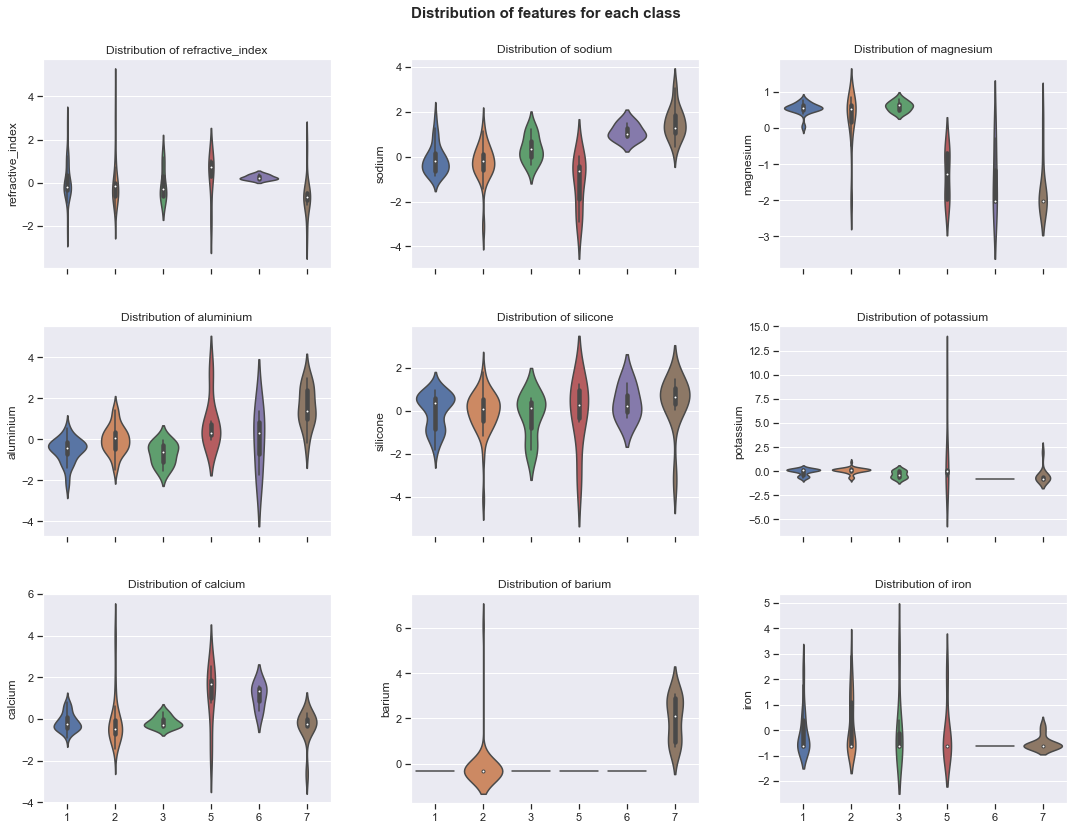

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12), sharex=True)
fig.tight_layout(pad=4.0)

train_scaled_adj = train_scaled.copy()
train_scaled_adj['target'] = y

labels = list(np.unique(y))
for i in range(len(axs)):
    for j in range(len(axs[i])):

        # Relevant ax
        ax = axs[i][j]
        
        # Relevant feature
        feature = features_names[i*3 + j]
        
        # Plot
        sns.violinplot(data=train_scaled_adj, y=feature, x='target', ax=ax, inner='box')
        
        # Set correspodning labels
        ax.set_xlabel('')
        ax.set_title(f'Distribution of {feature}', size=12)

        
fig.suptitle('Distribution of features for each class', fontsize=15, y=1.0, weight='bold');
fig.savefig(f"{PATH_TO['data']['figures']}/fdist_violin.jpg")

### PCA best two components

From this plot, we can see that certain classes quite overlap, e.g. `class 1` and `class 2.` Weshould also note that the first two components only explain 51 % of the variance, which clearly is not enough to be able to separate the classes well enough. 

In [21]:
print(f"Percentage of explained variance by first two components: {round(expl_var['train'][:2].sum()*100, 2)} %")

Percentage of explained variance by first two components: 51.14 %


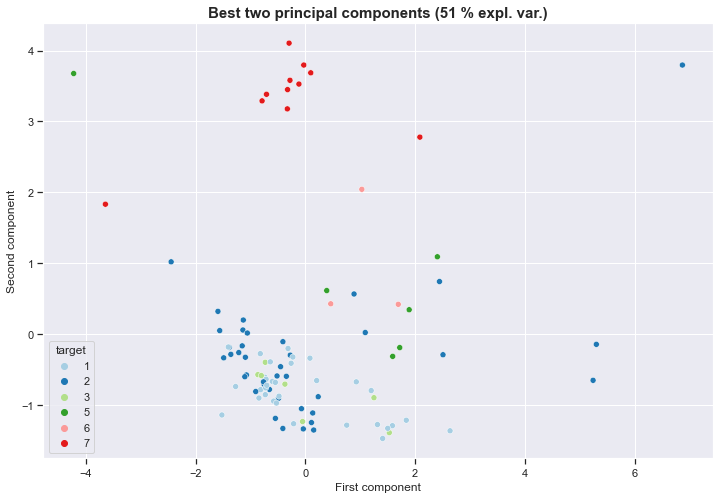

In [22]:
train_pca_adj = train_pca.copy()
train_pca_adj['target'] = y

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=train_pca_adj, x=0, y=1, ax=ax, hue='target', palette=sns.color_palette("Paired", n_colors=6));

ax.set_title('Best two principal components (51 % expl. var.)', fontsize=15, weight='bold')
ax.set_xlabel('First component')
ax.set_ylabel('Second component')

fig.savefig(f"{PATH_TO['data']['figures']}/pca_best2_scatter.jpg")

## 03 Custom Implementations
---

## #04 Training and Evaluating Models
---

### Decision Trees
---

### Neural Networks
---

### Ensemble Classifier
---